# Proteomics analysis of PPMI 
In this project we analyse **Cerebrospinal Fluid (CSF) proteomic** data of Parkinson's disease patients.
- CSF is a clear fluid that surrounds the brain and spinal cord. It provides a protective cushion for the brain and helps remove waste products.
- The collected CSF can be analyzed to look for various markers, proteins, or other substances that may be indicative of neurological conditions, including Parkinson's disease.

In this study we look at proteomic data

In [1]:
import pandas as pd
import numpy as np
import os
import glob
import functools
from pathlib import Path
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

from sklearn.metrics import precision_score, recall_score, f1_score, roc_curve, accuracy_score
from sklearn.metrics import roc_auc_score, confusion_matrix, precision_recall_curve

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import StratifiedKFold
from sklearn.inspection import permutation_importance
from sklearn.preprocessing import LabelEncoder
from xgboost import XGBClassifier

from sklearn.feature_selection import SelectFromModel
from sklearn.utils import class_weight

# In case you do not have following packages installed, uncomment instalisation.

#!pip3 install xgboost
#from xgboost import XGBClassifier


### Data to be loaded ###

In [2]:
path2 = Path("/home/znazari/data")# the path to the data
path3 = Path("/home/znazari/data/open_proteomic/")


In [3]:
proteomic_annotation = pd.read_csv(path3/"PPMI_Project_151_pqtl_Analysis_Annotations_20210210.csv",delimiter=',')
proteomic_annotation

,CHIP_PROBE_ID,SOMA_SEQ_ID,Unnamed: 2,TARGET_GENE_ID,TARGET_GENE_SYMBOL,ORGANISM,DESCRIPTION_HH,Unnamed: 7,Unnamed: 8,Unnamed: 9,...,Unnamed: 51,Unnamed: 52,Unnamed: 53,Unnamed: 54,Unnamed: 55,Unnamed: 56,Unnamed: 57,Unnamed: 58,Unnamed: 59,Unnamed: 60
0,anti-10000-28_1,10000-28_3,NaN,1415.0,CRYBB2,Human,"crystallin, beta B2",NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,anti-10001-7_1,10001-7_3,NaN,5894.0,RAF1,Human,v-raf-1 murine leukemia viral oncogene homolog 1,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,anti-10003-15_1,10003-15_3,NaN,7592.0,ZNF41,Human,zinc finger protein 41,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,anti-10006-25_1,10006-25_3,NaN,2002.0,ELK1,Human,"ELK1, member of ETS oncogene family",NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,anti-10008-43_17,10008-43_3,NaN,2978.0,GUCA1A,Human,guanylate cyclase activator 1A (retina),NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5188,anti-9993-11_1,9993-11_3,NaN,9422.0,ZNF264,Human,zinc finger protein 264,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5189,anti-9994-217_11,9994-217_3,NaN,496.0,ATP4B,Human,"ATPase, H+/K+ exchanging, beta polypeptide",NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5190,anti-9995-6_1,9995-6_3,NaN,1854.0,DUT,Human,deoxyuridine triphosphatase,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5191,anti-9997-12_1,9997-12_3,NaN,23190.0,UBXN4,Human,UBX domain protein 4,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [4]:
proteomic = pd.read_csv(path3/"Project_151_pQTL_in_CSF_1_of_7_Batch_Corrected_.csv",delimiter=',')
proteomic

,PATNO,SEX,COHORT,CLINICAL_EVENT,TYPE,TESTNAME,TESTVALUE,UNITS,PLATEID,RUNDATE,PROJECTID,PI_NAME,PI_INSTITUTION,update_stamp
0,53595,Female,PD,BL,Cerebrospinal Fluid,5632-6_3,10.182013,log2 RFU,P0022899,2019-08-04,151,David Stone,Merck,2022-05-13 10:38:41.0
1,53595,Female,PD,BL,Cerebrospinal Fluid,5631-83_3,6.346285,log2 RFU,P0022899,2019-08-04,151,David Stone,Merck,2022-05-13 10:38:41.0
2,53595,Female,PD,BL,Cerebrospinal Fluid,5630-48_3,12.943830,log2 RFU,P0022899,2019-08-04,151,David Stone,Merck,2022-05-13 10:38:41.0
3,53595,Female,PD,BL,Cerebrospinal Fluid,5629-58_3,5.891402,log2 RFU,P0022899,2019-08-04,151,David Stone,Merck,2022-05-13 10:38:41.0
4,53595,Female,PD,BL,Cerebrospinal Fluid,5628-21_3,12.836350,log2 RFU,P0022899,2019-08-04,151,David Stone,Merck,2022-05-13 10:38:41.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
803875,3825,Male,PD,BL,Cerebrospinal Fluid,12908-15_3,6.522282,log2 RFU,P0022899,2019-08-04,151,David Stone,Merck,2022-05-13 10:38:08.0
803876,3825,Male,PD,BL,Cerebrospinal Fluid,12906-137_3,6.020084,log2 RFU,P0022899,2019-08-04,151,David Stone,Merck,2022-05-13 10:38:08.0
803877,3825,Male,PD,BL,Cerebrospinal Fluid,12904-180_3,4.182774,log2 RFU,P0022899,2019-08-04,151,David Stone,Merck,2022-05-13 10:38:08.0
803878,3825,Male,PD,BL,Cerebrospinal Fluid,12900-29_3,7.283812,log2 RFU,P0022899,2019-08-04,151,David Stone,Merck,2022-05-13 10:38:08.0


In [5]:
# Specify the base file name and path
base_file_name = "Project_151_pQTL_in_CSF_{}_of_7_Batch_Corrected_.csv"

# Number of files
num_files = 7

# List to store DataFrames
dfs = []

# Loop through the file indices and read each file
for file_index in range(1, num_files + 1):
    file_name = base_file_name.format(file_index)
    file_path = path3 / file_name
    
    # Check if the file exists before attempting to read it
    if file_path.is_file():
        # Read the CSV file and append it to the list
        df = pd.read_csv(file_path, delimiter=',')
        dfs.append(df)
    else:
        print(f"File {file_name} not found.")


In [8]:
dfs[6]

,PATNO,SEX,COHORT,CLINICAL_EVENT,TYPE,TESTNAME,TESTVALUE,UNITS,PLATEID,RUNDATE,PROJECTID,PI_NAME,PI_INSTITUTION,update_stamp
0,59649,Male,PD,BL,Cerebrospinal Fluid,5632-6_3,11.026966,log2 RFU,P0024868,2019-02-12,151,David Stone,Merck,2022-05-13 10:38:41.0
1,59649,Male,PD,BL,Cerebrospinal Fluid,5631-83_3,6.609041,log2 RFU,P0024868,2019-02-12,151,David Stone,Merck,2022-05-13 10:38:41.0
2,59649,Male,PD,BL,Cerebrospinal Fluid,5630-48_3,13.466670,log2 RFU,P0024868,2019-02-12,151,David Stone,Merck,2022-05-13 10:38:41.0
3,59649,Male,PD,BL,Cerebrospinal Fluid,5629-58_3,5.835645,log2 RFU,P0024868,2019-02-12,151,David Stone,Merck,2022-05-13 10:38:41.0
4,59649,Male,PD,BL,Cerebrospinal Fluid,5628-21_3,12.769220,log2 RFU,P0024868,2019-02-12,151,David Stone,Merck,2022-05-13 10:38:41.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
722530,3917,Male,Control,BL,Cerebrospinal Fluid,9745-20_3,6.931300,log2 RFU,P0024869,2019-02-12,151,David Stone,Merck,2022-05-13 10:39:16.0
722531,3917,Male,Control,BL,Cerebrospinal Fluid,9747-48_3,7.043459,log2 RFU,P0024869,2019-02-12,151,David Stone,Merck,2022-05-13 10:39:16.0
722532,3917,Male,Control,BL,Cerebrospinal Fluid,9748-31_3,8.461362,log2 RFU,P0024869,2019-02-12,151,David Stone,Merck,2022-05-13 10:39:16.0
722533,3917,Male,Control,BL,Cerebrospinal Fluid,9749-190_3,9.049630,log2 RFU,P0024869,2019-02-12,151,David Stone,Merck,2022-05-13 10:39:16.0


In [9]:
# Concatenate all DataFrames into a single DataFrame
result_df = pd.concat(dfs, ignore_index=True)

# Filter out patients diagnosed as Prodromal
result_df = result_df[result_df['COHORT'] != 'Prodromal']

# Pivot the DataFrame to get the desired format
result_pivot = result_df.pivot(index='TESTNAME', columns='PATNO', values='TESTVALUE')



In [20]:
result_pivot

PATNO,3000,3001,3002,3003,3004,3006,3007,3008,3009,3010,...,74067,74199,74817,75409,75421,75480,75484,75505,75524,75562
TESTNAME,,,,,,,,,,,,,,,,,,,,,
10000-28_3,7.016730,7.454336,7.247439,7.010630,6.877898,6.842311,7.754820,7.001725,6.820676,7.104007,...,6.899428,6.816018,6.853592,6.781720,6.924048,6.758358,6.870476,6.844687,7.029326,6.666132
10001-7_3,7.870548,8.121843,8.344479,7.222104,7.650171,7.092575,7.806605,8.196070,7.769967,7.359637,...,7.997572,7.275574,7.427730,7.834432,8.015048,7.337290,7.599946,7.499072,7.612910,7.258944
10003-15_3,6.147252,6.222071,6.065235,6.138153,6.203758,6.221370,6.174415,6.171208,6.280763,6.188014,...,6.324074,6.192135,6.248550,6.312524,6.219102,6.054284,6.384542,6.236579,6.343984,6.186476
10006-25_3,6.371610,6.418159,6.365775,6.357083,6.361865,6.183732,6.238306,6.332403,6.393692,6.567999,...,6.303177,6.577943,6.329391,6.163935,6.480985,6.350333,6.355463,6.292218,6.339972,6.344696
10008-43_3,5.882283,5.934242,5.827745,5.914232,5.893985,6.054652,5.939613,6.070155,5.952001,5.913274,...,5.988861,5.892367,5.974385,5.883404,5.922584,6.049692,5.950037,5.970764,5.944815,5.865619
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9993-11_3,6.230929,6.209682,6.586607,6.225973,6.257445,6.412115,7.233072,5.979002,6.252459,6.274228,...,6.218115,6.537651,6.495690,6.300791,6.372259,6.215987,6.386449,6.247486,6.541717,6.430384
9994-217_3,7.031689,7.129638,7.345001,7.330257,7.413496,7.024051,6.918511,6.947370,7.070061,7.149448,...,7.076340,7.068358,7.308743,7.017250,6.983826,7.071633,7.193699,7.390031,7.071616,7.576549
9995-6_3,9.630040,9.827683,9.805028,8.835570,9.094281,8.520557,9.484474,9.514471,9.189601,9.000802,...,9.627819,9.281438,9.397977,9.215428,9.766957,8.772783,9.377158,9.155109,9.443181,9.159902


In [25]:
result_pivot_filtered

PATNO,3000,3001,3002,3003,3004,3006,3007,3008,3009,3010,...,4121,4122,4123,4124,4125,4126,4135,4136,4139,41410
TESTNAME,,,,,,,,,,,,,,,,,,,,,
10000-28_3,7.016730,7.454336,7.247439,7.010630,6.877898,6.842311,7.754820,7.001725,6.820676,7.104007,...,6.996939,6.838948,6.935341,6.938593,6.743564,6.879410,7.047316,6.894967,6.768009,6.610080
10001-7_3,7.870548,8.121843,8.344479,7.222104,7.650171,7.092575,7.806605,8.196070,7.769967,7.359637,...,8.012181,7.855806,8.035597,8.196864,7.766080,7.773577,7.825966,7.479678,7.780084,7.602446
10003-15_3,6.147252,6.222071,6.065235,6.138153,6.203758,6.221370,6.174415,6.171208,6.280763,6.188014,...,6.320647,6.416003,6.275744,6.149764,6.164363,6.323608,6.161733,6.171370,6.253532,6.240810
10006-25_3,6.371610,6.418159,6.365775,6.357083,6.361865,6.183732,6.238306,6.332403,6.393692,6.567999,...,6.348242,6.437493,6.301871,6.312332,6.423467,6.403437,6.363899,6.400867,6.433781,6.435529
10008-43_3,5.882283,5.934242,5.827745,5.914232,5.893985,6.054652,5.939613,6.070155,5.952001,5.913274,...,5.958741,6.001704,5.896644,6.025008,5.837845,5.918820,5.846805,6.181146,5.925006,5.976737
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9993-11_3,6.230929,6.209682,6.586607,6.225973,6.257445,6.412115,7.233072,5.979002,6.252459,6.274228,...,6.164821,6.167718,6.148084,6.120723,6.348303,6.229989,6.162735,6.375987,6.529382,6.481852
9994-217_3,7.031689,7.129638,7.345001,7.330257,7.413496,7.024051,6.918511,6.947370,7.070061,7.149448,...,7.016618,7.318267,7.170244,7.052944,7.128567,7.139254,7.292240,7.036760,7.025085,7.114605
9995-6_3,9.630040,9.827683,9.805028,8.835570,9.094281,8.520557,9.484474,9.514471,9.189601,9.000802,...,9.602305,9.572287,9.585365,9.752996,9.752487,9.334244,9.307760,9.011721,9.608131,8.949228


In [10]:
file_path = "/home/znazari/data/open_proteomic/patients_proteomics.csv"
# Write the DataFrame to a CSV file
result_pivot.to_csv(file_path, index=True)

In [11]:
mutation_patients = pd.read_csv(path2/"mutated_g_patients.csv")
mutation_patients

,PATNO
0,40012
1,40067
2,40163
3,40273
4,40338
...,...
758,142394
759,142848
760,148092
761,150110


In [12]:
result_pivot_filtered = result_pivot.drop(columns=mutation_patients['PATNO'], errors='ignore')

In [13]:
patient_diagnosis_df = result_df[['PATNO', 'COHORT']].drop_duplicates()

In [ ]:
patient_diagnosis_df

In [14]:
file_path2 = "/home/znazari/data/open_proteomic/patients_diagnosis.csv"
patient_diagnosis_df.to_csv(file_path2, index=False)

In [15]:
new_patients_diagnos = patient_diagnosis_df[~patient_diagnosis_df['PATNO'].isin(mutation_patients['PATNO'])]


In [16]:
new_patients_diagnos

,PATNO,COHORT
4785,3029,Control
9570,3963,PD
14355,3316,Control
19140,3124,PD
23925,3175,PD
...,...,...
5512320,3812,Control
5517105,3817,Control
5521890,3792,PD
5526675,3793,PD


In [17]:
# Assuming you have two DataFrames: result_pivot and patient_diagnosis_df

#  Merge the two DataFrames on 'PATNO'
merged_df = pd.merge(result_pivot_filtered.T, new_patients_diagnos, on='PATNO')

# Separate features (X) and target variable (y)
X = merged_df.drop(['PATNO', 'COHORT'], axis=1)
y = merged_df['COHORT']

# Convert diagnosis labels to numeric values using LabelEncoder
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.3, random_state=42)

#  Initialize and train the XGBoost model
xgb_model = XGBClassifier()
xgb_model.fit(X_train, y_train)

#  Make predictions on the testing set
y_pred_proba = xgb_model.predict_proba(X_test)[:, 1]

# Calculate AU-ROC score
au_roc_score = roc_auc_score(y_test, y_pred_proba)

# Print the AU-ROC score
print(f'AU-ROC Score: {au_roc_score}')



AU-ROC Score: 0.7596714361420243


In [18]:
# Assuming you have two DataFrames: result_pivot and patient_diagnosis_df

#  Merge the two DataFrames on 'PATNO'
merged_df = pd.merge(result_pivot.T, patient_diagnosis_df, on='PATNO')

# Separate features (X) and target variable (y)
X = merged_df.drop(['PATNO', 'COHORT'], axis=1)
y = merged_df['COHORT']

# Convert diagnosis labels to numeric values using LabelEncoder
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.3, random_state=42)

#  Initialize and train the XGBoost model
xgb_model = XGBClassifier()
xgb_model.fit(X_train, y_train)

#  Make predictions on the testing set
y_pred_proba = xgb_model.predict_proba(X_test)[:, 1]

# Calculate AU-ROC score
au_roc_score = roc_auc_score(y_test, y_pred_proba)

# Print the AU-ROC score
print(f'AU-ROC Score: {au_roc_score}')



AU-ROC Score: 0.7742836547125608


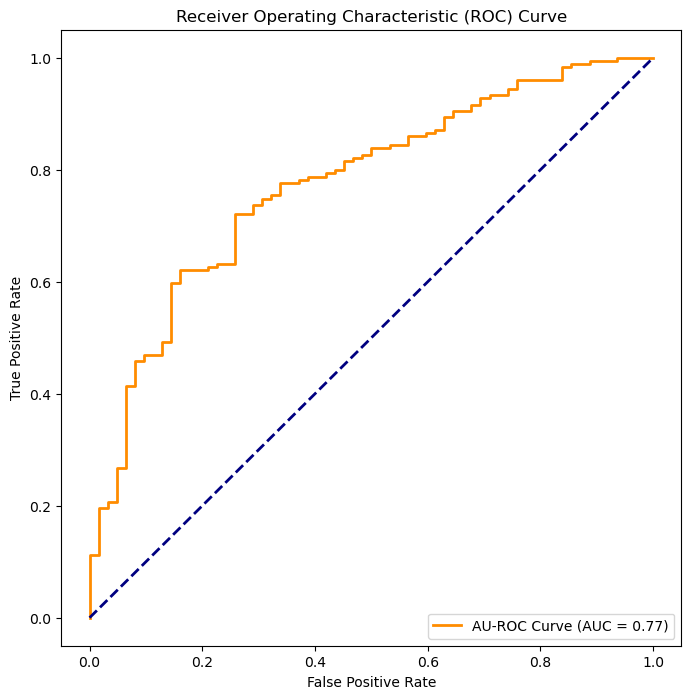

In [19]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# Calculate the false positive rate (FPR) and true positive rate (TPR)
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)

# Calculate the Area Under the ROC Curve (AUC)
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.figure(figsize=(8, 8))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'AU-ROC Curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()


AU-ROC Score: 0.7742836547125608
Classification Report:
              precision    recall  f1-score   support

     Control       0.59      0.16      0.25        62
          PD       0.77      0.96      0.85       179

    accuracy                           0.76       241
   macro avg       0.68      0.56      0.55       241
weighted avg       0.72      0.76      0.70       241



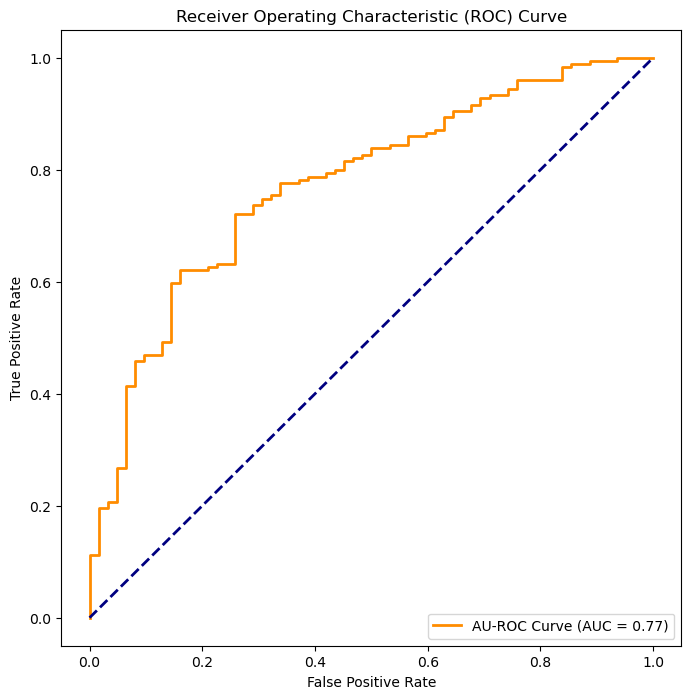

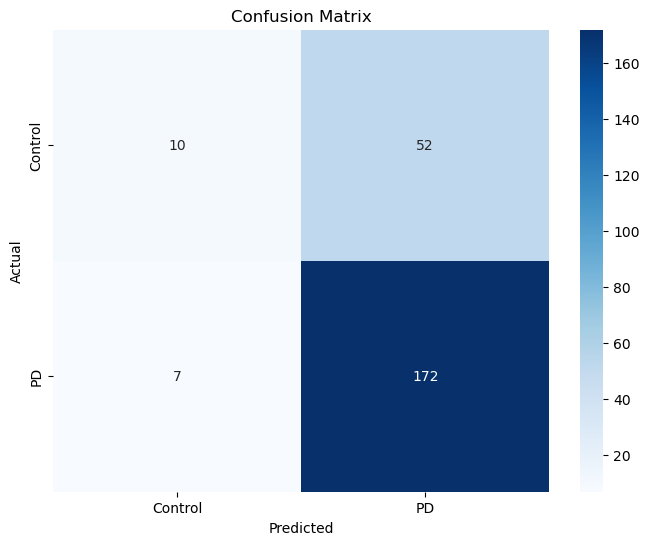

In [22]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, confusion_matrix, plot_confusion_matrix
from sklearn.metrics import classification_report
import seaborn as sns

# Calculate AU-ROC score
au_roc_score = roc_auc_score(y_test, y_pred_proba)

# Print the AU-ROC score
print(f'AU-ROC Score: {au_roc_score}')

# Plot ROC curve
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 8))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'AU-ROC Curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.savefig('roc_prot.png')

# Predictions on the testing set
y_pred = xgb_model.predict(X_test)

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)

# Plot Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.savefig('confusion_prot.png')

# Classification Report
print('Classification Report:')
print(classification_report(y_test, y_pred, target_names=label_encoder.classes_))


- Accuracy: (TP + TN) / (TP + TN + FP + FN)
- Precision: TP / (TP + FP)
- Recall (Sensitivity or True Positive Rate): TP / (TP + FN)
- Specificity (True Negative Rate): TN / (TN + FP)
- F1 Score: 2 * (Precision * Recall) / (Precision + Recall)

In [ ]:

# Merge the two DataFrames on 'PATNO'
merged_df = pd.merge(result_pivot.T, patient_diagnosis_df, on='PATNO')

# Separate features (X) and target variable (y)
X = merged_df.drop(['PATNO', 'COHORT'], axis=1)
y = merged_df['COHORT']

# Convert diagnosis labels to numeric values using LabelEncoder
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# Initialize StratifiedKFold for cross-validation
n_splits = 10  # Number of folds
skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

# Initialize an array to store AU-ROC scores
au_roc_scores = []

# Perform cross-validation and repeat XGBoost algorithm
for _ in range(5):  # Repeat 5 times
    for train_index, test_index in skf.split(X, y_encoded):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y_encoded[train_index], y_encoded[test_index]

        # Initialize and train the XGBoost model
        xgb_model = XGBClassifier()
        xgb_model.fit(X_train, y_train)

        # Make predictions on the testing set
        y_pred_proba = xgb_model.predict_proba(X_test)[:, 1]

        # Calculate AU-ROC score
        au_roc_score = roc_auc_score(y_test, y_pred_proba)

        # Append the AU-ROC score to the array
        au_roc_scores.append(au_roc_score)

# Calculate the average AU-ROC score over all repetitions and folds
average_au_roc_score = sum(au_roc_scores) / len(au_roc_scores)

# Print the average AU-ROC score
print(f'Average AU-ROC Score: {average_au_roc_score}')
